# CNN 과제


# 라이브러리

In [2]:
import datetime
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.model_selection import train_test_split

# GPU 할당
(train 시 재할당 및 할당정보 재확인하긴 함)

In [3]:
print(f"CUDA Available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")

CUDA Available: True
Current Device: cuda


# Download Dataset & Applying Augmentation

> 37 category pet dataset with roughly 200 images for each class

## total : 7349
- Cat : 2371
- Dog : 4978



100%|██████████| 792M/792M [01:12<00:00, 10.9MB/s]


Extracting pets/oxford-iiit-pet/images.tar.gz to pets/oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:02<00:00, 7.02MB/s]


Extracting pets/oxford-iiit-pet/annotations.tar.gz to pets/oxford-iiit-pet
raw train dataset 개수:  3680
['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier']
클래스 종류 :  37


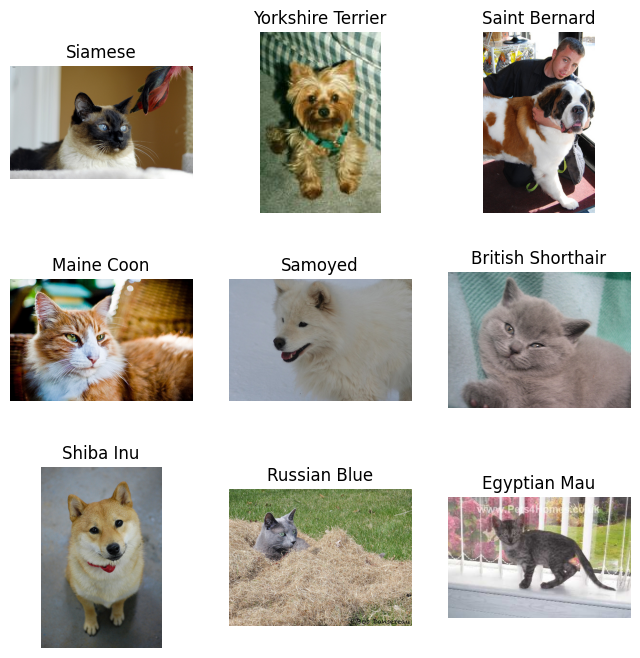

In [4]:
from torchvision.datasets import OxfordIIITPet

# 다운로드 및 확인
dataset = OxfordIIITPet('pets', download=True)
print("raw train dataset 개수: ", len(dataset))
print(dataset.classes)
print("클래스 종류 : ", len(dataset.classes))

# 데이터 시각화를 위한 함수 (transform 적용 전)
def plot_raw_images(dataset, num_images=9):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(dataset.classes[label])
        plt.axis("off")
        plt.imshow(img)
    plt.show()

# transform 적용 전 데이터 시각화
plot_raw_images(dataset)

# Data Preprocessing Definition

- Augmentation
- normalize

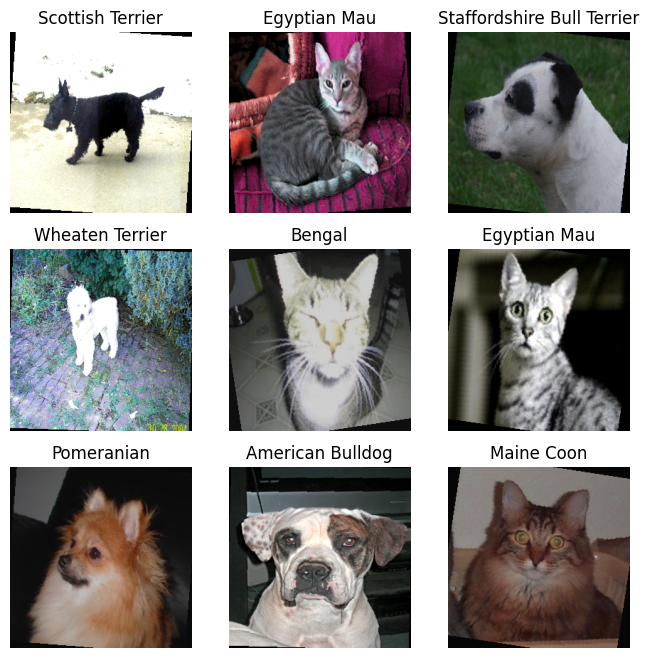

In [5]:
transform = transforms.Compose([

    # all images to same size
    transforms.Resize((256, 256)),
    transforms.ToTensor(),

    # augmentation
    transforms.RandomHorizontalFlip(),  # 좌우 뒤집기
    transforms.RandomRotation(15),  # 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),

    # normalize
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


# transform 적용
dataset = OxfordIIITPet('pets', transform=transform)


# (TMI) - 데이터 증강 관련 기법 적용하면 어떻게 되는지 보려고 시각화하는 거임
# Transform 적용 후 데이터 확인
def plot_transformed_images(dataset, num_images=9):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        img = img.permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
        img = img * 0.5 + 0.5  # 정규화 해제 (Normalize의 역변환)
        figure.add_subplot(rows, cols, i)
        plt.title(dataset.classes[label])
        plt.axis("off")
        plt.imshow(img.numpy())
    plt.show()

# Transform 적용 후 데이터 시각화
plot_transformed_images(dataset)

# Dataset Preprocess / Preparation
- Data Split
- Data Load


전체 데이터셋 크기: 3680
훈련 데이터셋 크기: 2944
검증 데이터셋 크기: 368
Train 데이터 시각화


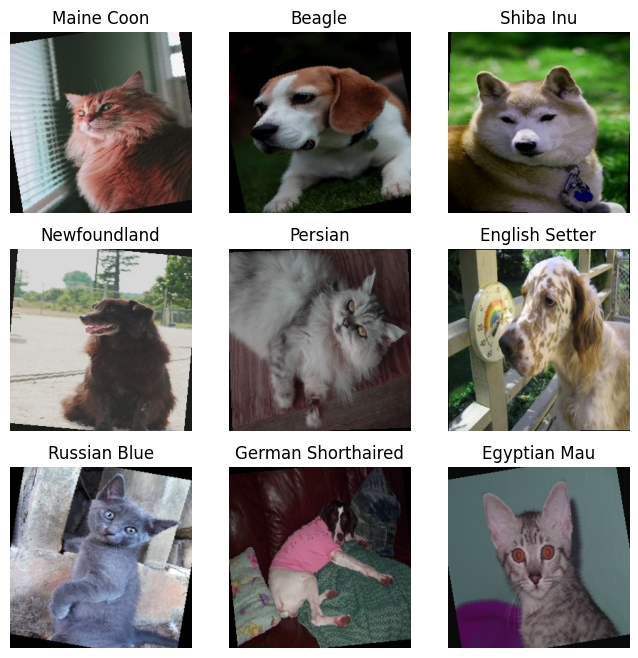

Validation 데이터 시각화


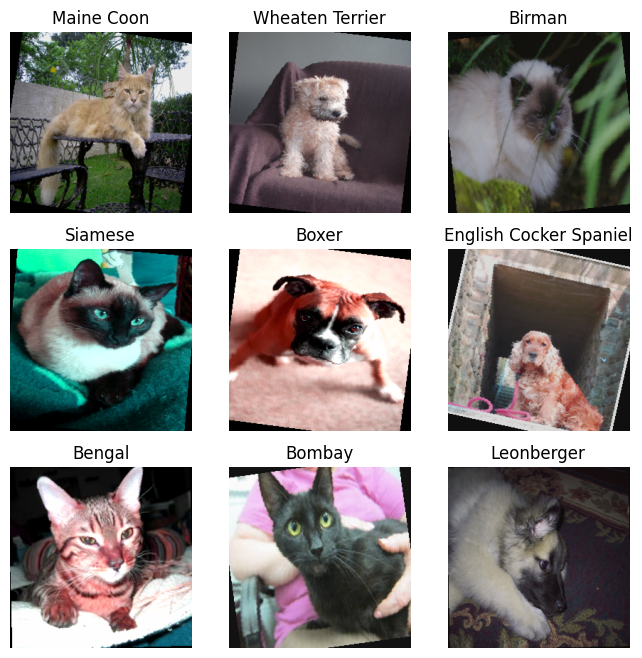

In [6]:
from torch.utils.data import random_split, DataLoader

# Train, Validation, Test 분할
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 결과 확인
print(f"전체 데이터셋 크기: {len(dataset)}")
print(f"훈련 데이터셋 크기: {len(train_dataset)}")
print(f"검증 데이터셋 크기: {len(val_dataset)}")

### (SUB)Visualization

In [ ]:
# DataLoader 데이터 시각화
def visualize_data(loader, classes, num_images=9):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i, (img, label) in enumerate(loader):
        if i == num_images:
            break
        img = img[0].permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
        img = img * 0.5 + 0.5  # Normalize 해제
        figure.add_subplot(rows, cols, i + 1)
        plt.title(classes[label[0]])
        plt.axis("off")
        plt.imshow(img.numpy())
    plt.show()

# Train 데이터 시각화
print("Train 데이터 시각화")
visualize_data(train_loader, dataset.classes)

# Validation 데이터 시각화
print("Validation 데이터 시각화")
visualize_data(val_loader, dataset.classes)

# Creating a Custom Dataset

In [7]:
import os
from torchvision.datasets import OxfordIIITPet
from torchvision.io import read_image
from torch.utils.data import Dataset
import pandas as pd

class MyCustomImageDataset(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):

        # OxfordIIITPet 데이터에서 필요한 정보 추출
        self.data = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 이미지 및 레이블 가져오기
        img, label = self.data[idx]
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
        return img, label

# Bottleneck Residual Block
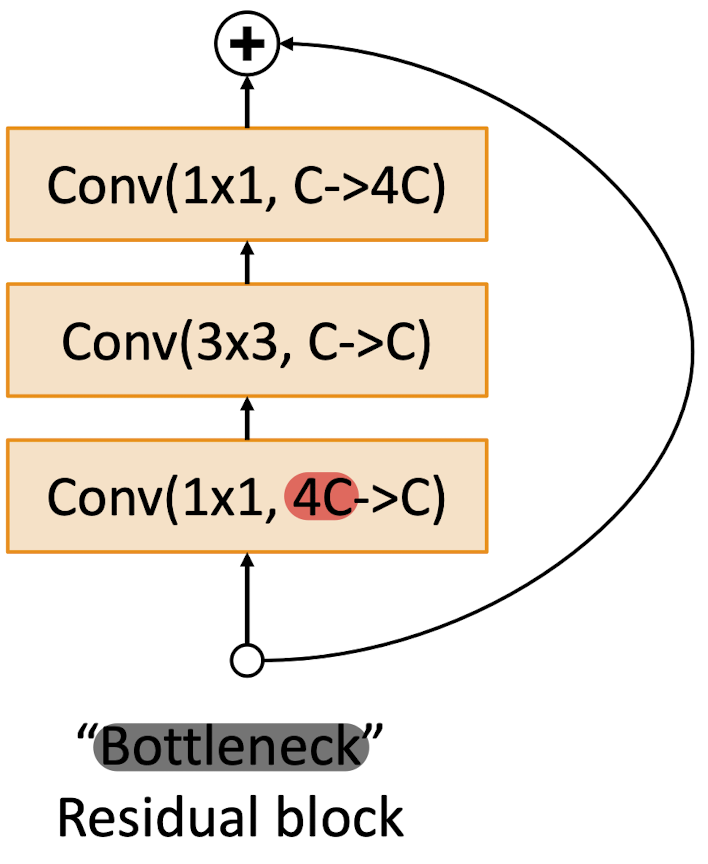

In [8]:
import torch.nn.functional as F

class BottleneckBlock(nn.Module) :
    def __init__(self, in_channels, out_channels, stride=1, expansion =4):
        super(BottleneckBlock, self).__init__()
        mid_channels = out_channels // expansion

        # 1x1 Conv (channel 축소)
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)

        # 3x3 conv
        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)

        # 1x1 Conv (channel 증가)
        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        # Skip connection
        self.skip_conv = None
        if stride != 1 or in_channels != out_channels:
            self.skip_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            self.skip_bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        identity = x
        if self.skip_conv:
            identity = self.skip_bn(self.skip_conv(x))

        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        out = out + identity
        return F.relu(out)


# CNN based ResNet50 Model

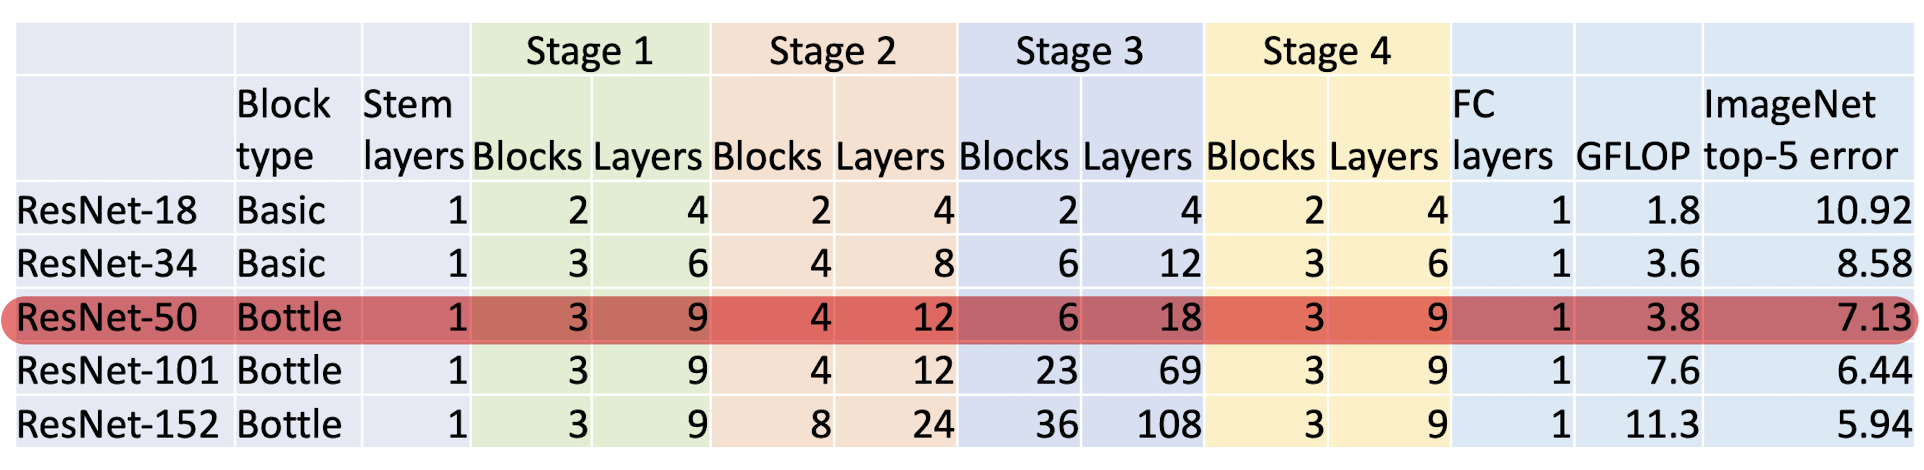

> ResNet 50의 Block 구성:

	•	Stage 1: 3 blocks

	•	Stage 2: 4 blocks

	•	Stage 3: 6 blocks

	•	Stage 4: 3 blocks

In [9]:
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()

        # 초기 Conv 레이어
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual Blocks
        self.layer1 = self._make_layer(BottleneckBlock, 64, 256, num_blocks=3, stride=1)
        self.layer2 = self._make_layer(BottleneckBlock, 256, 512, num_blocks=4, stride=2)
        self.layer3 = self._make_layer(BottleneckBlock, 512, 1024, num_blocks=6, stride=2)
        self.layer4 = self._make_layer(BottleneckBlock, 1024, 2048, num_blocks=3, stride=2)

        # Global Average Pooling + Fully Connected Layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)

    def _make_layer(self, block, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(in_channels, out_channels, stride))  # 첫 번째 Block
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))  # 나머지 Block
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# 랜덤시드

In [10]:
import random

def set_random_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)

set_random_seed(2025)

# Training / Evaluation


In [22]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = (correct / total) * 100
    return avg_loss, accuracy


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # ==== 이미지를 1d vector로 변환하는 MLP와 다르게, ResNet50은 이미지로 받음 === #
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_loss /= len(train_loader)
        train_acc = (correct / total) * 100

        # Validation
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}%")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"Early Stopping Counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        scheduler.step() # scheduler update - learning rate를 점차적으로 줄일 때만 사용

# 학습 셋팅

- Loss function
- Optimizer

In [23]:
import torch.optim as optimizer
from torch.optim.lr_scheduler import StepLR

num_classes = 37
learning_rate = 0.001
epochs = 50
patience = 7

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# model
model = ResNet50(num_classes=num_classes).to(device)

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optimizer.Adam(model.parameters(), lr=learning_rate)
# 스텝하면서 러닝레이트 줄임
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

cuda


In [ ]:
# 학습 및 평가
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs, patience = patience)

# Test 데이터로 최종 평가
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch [1/50] Train Loss: 3.8826, Train Acc: 3.1929, Val Loss: 4.8274, Val Acc: 4.3478
Epoch [2/50] Train Loss: 3.6254, Train Acc: 4.7554, Val Loss: 3.5880, Val Acc: 2.7174
Epoch [3/50] Train Loss: 3.5682, Train Acc: 4.7215, Val Loss: 3.5464, Val Acc: 4.8913
Epoch [4/50] Train Loss: 3.4941, Train Acc: 6.8274, Val Loss: 3.5016, Val Acc: 6.5217
Epoch [5/50] Train Loss: 3.4523, Train Acc: 7.7785, Val Loss: 4.3300, Val Acc: 7.3370
Early Stopping Counter: 1/7
Epoch [6/50] Train Loss: 3.4234, Train Acc: 8.6957, Val Loss: 3.4958, Val Acc: 6.5217
Epoch [7/50] Train Loss: 3.3863, Train Acc: 7.8465, Val Loss: 3.3297, Val Acc: 9.5109
Epoch [8/50] Train Loss: 3.3234, Train Acc: 9.2052, Val Loss: 3.3779, Val Acc: 8.6957
Early Stopping Counter: 1/7
Epoch [9/50] Train Loss: 3.2789, Train Acc: 11.1753, Val Loss: 3.3494, Val Acc: 10.8696
Early Stopping Counter: 2/7
Epoch [10/50] Train Loss: 3.2649, Train Acc: 11.1413, Val Loss: 3.3147, Val Acc: 9.5109
Epoch [11/50] Train Loss: 3.2406, Train Acc: 11.5489

setting값

- learning rate 줄이기 사용 x
- lr = 0.0001
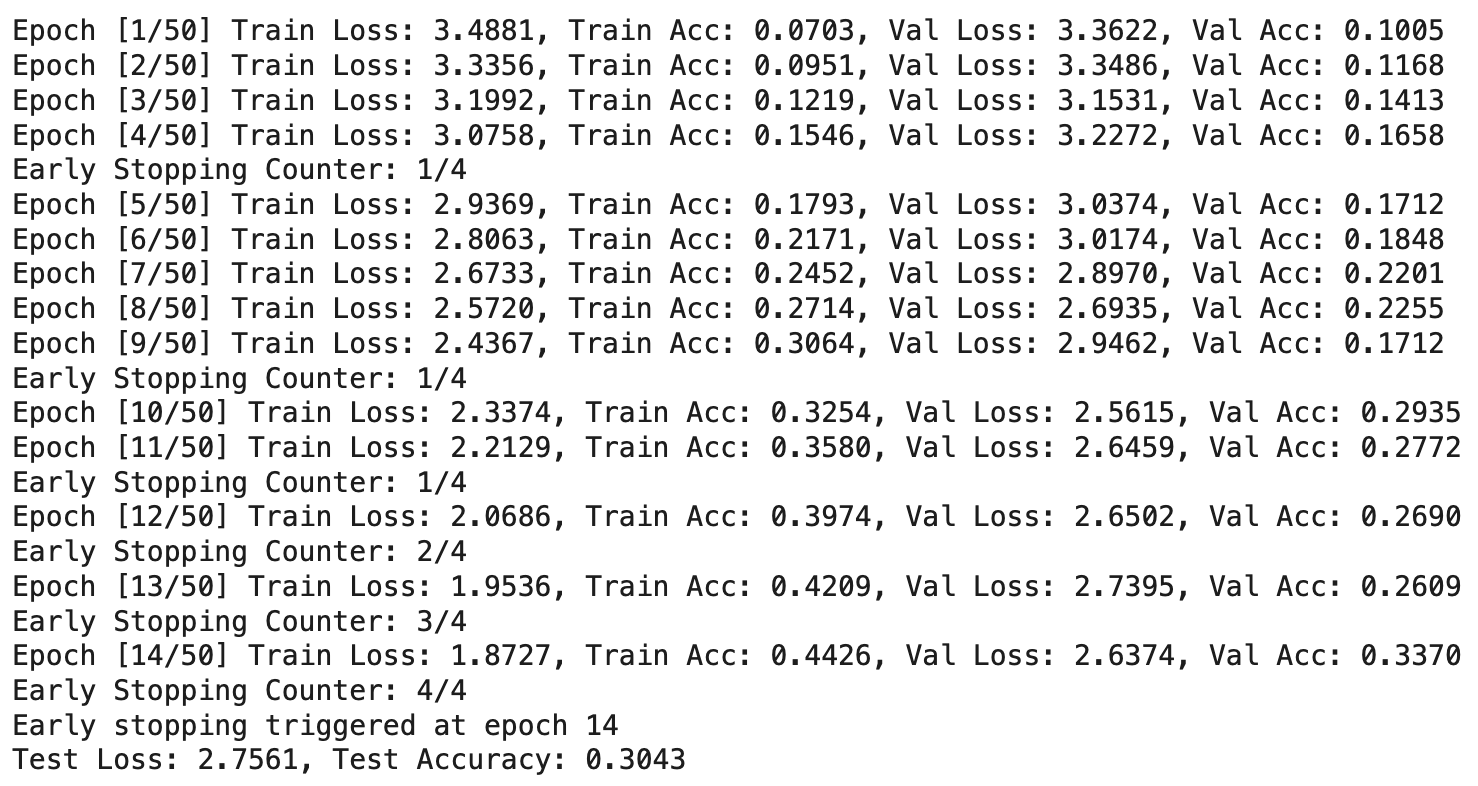

# setting 값

lr = 0.001에서 scheduler로 학습 줄이기
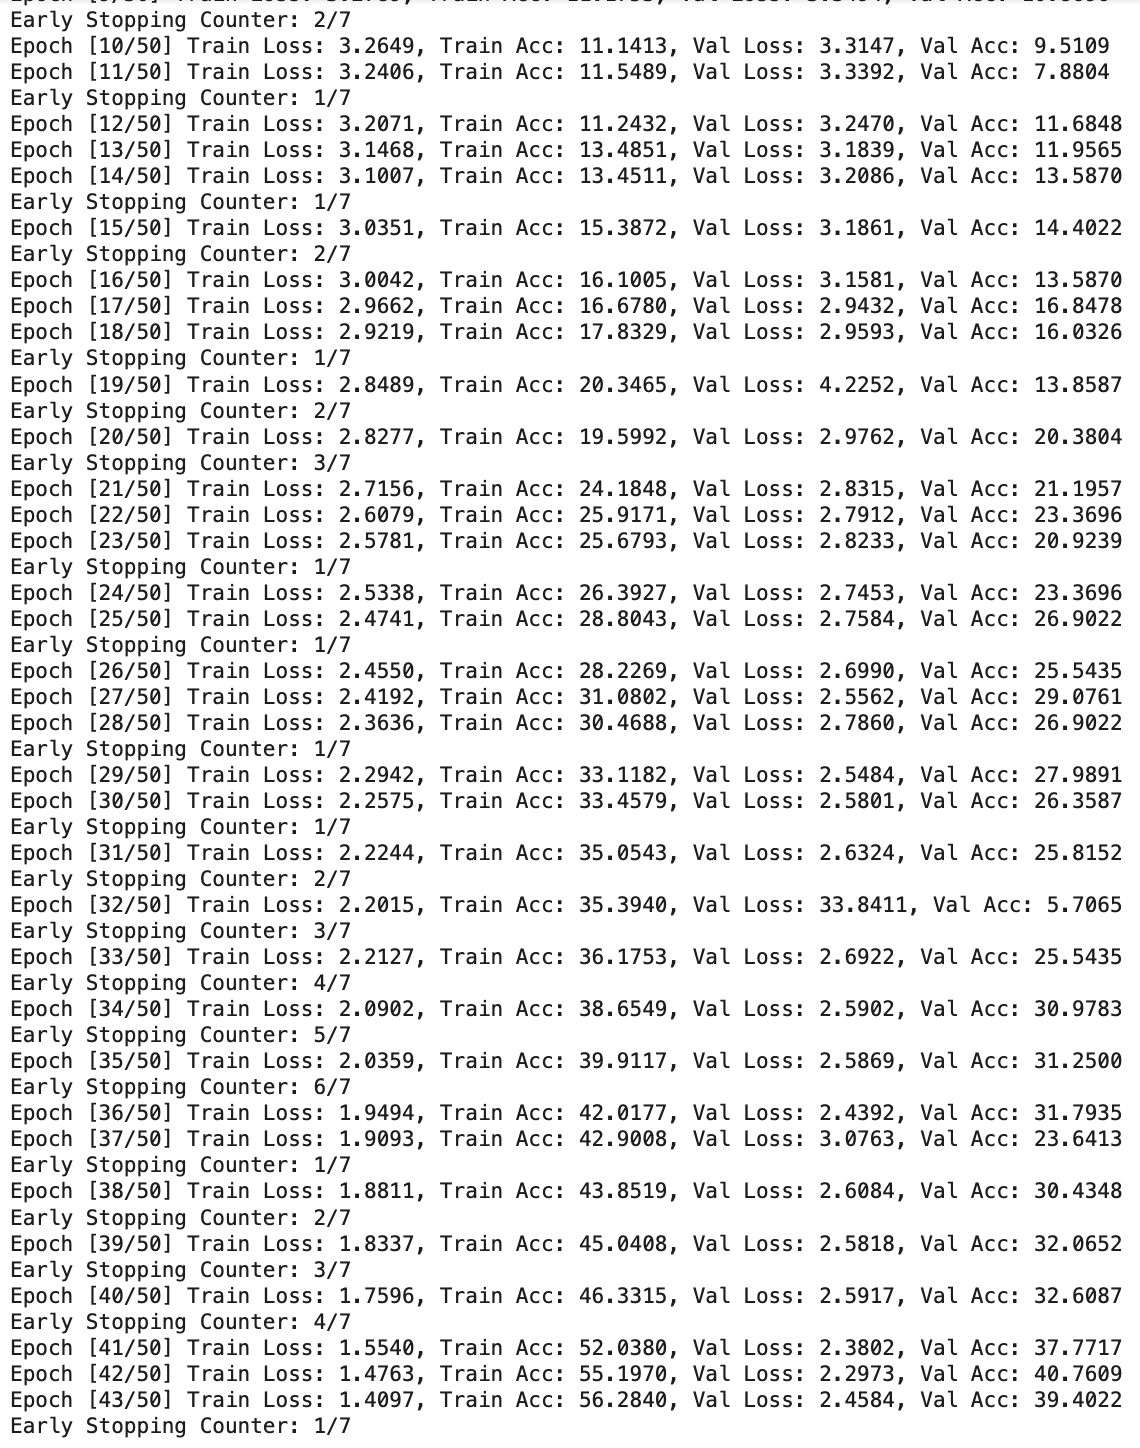